In [1]:
# I will first be trying out the language_check project to see if/how many clarity errors it can detect
import language_check
import spacy
import pandas as pd
import numpy as np
import math
import torch
from pytorch_pretrained_bert import OpenAIGPTTokenizer, OpenAIGPTModel, OpenAIGPTLMHeadModel
from sklearn.model_selection  import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stat

tool = language_check.LanguageTool('en-US')



# from spacy_grammar import grammar
nlp = spacy.load('en_core_web_md')
#grammar = Grammar(nlp)
#nlp.add_pipe(grammar)

In [2]:

data = pd.read_csv('Post_processing.csv', index_col=0)
#capitalize + add period NOTE: No further punctuation is added, which could have an effect on the grammar error detection.
data['exp'] = data['exp'].str.capitalize()+'.'

In [6]:
clarity_error_exps = data[data['label'] == 1]['exp']
good_exps = data[data['label'] == 5]['exp']
matches = {}

fails = {}
for idx,exp in clarity_error_exps.iteritems():
    m = tool.check(exp)
#     if m[0].ruleId == 'UPPERCASE_SENTENCE_START':
#         m = m[1:]
    if len(m)>0:    
        matches[idx] = [m, exp]
    else:
        matches[idx] = ['No Error Found', exp]
        fails[idx] = exp



## GPT 2 approach
from https://github.com/huggingface/transformers/issues/473


In [3]:

# Load pre-trained model (weights)
model = OpenAIGPTLMHeadModel.from_pretrained('openai-gpt')
model.eval()
# Load pre-trained model tokenizer (vocabulary)
tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')

def score(sentence):
    tokenize_input = tokenizer.tokenize(sentence)
    tensor_input = torch.tensor([tokenizer.convert_tokens_to_ids(tokenize_input)])
    loss=model(tensor_input, lm_labels=tensor_input)
    return math.exp(loss)



ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


In [8]:
# a=['there is a screen in the fridge',
#                 'there is a bag on the desk',
#                         'there is a book in the floor']
# print([score(i) for i in fails.values()])
# fails.values()


### Experiments:
Lets see how the scores compare between good and bad explanations. The bad explanations are randomly picked from the entries labeled clarity-error, while the good explanations are randomly picked from the entries labeled no error.

In [4]:
goodex,badex = np.random.choice(good_exps).capitalize()+'.', np.random.choice(clarity_error_exps).capitalize()+'.'

print(f"Goodex: {goodex} | score: {score(goodex)}\nbadex: {badex} | score: {score(badex)}")

#Note: looks a bit random, maybe need to normalize over length.

NameError: name 'good_exps' is not defined

Next I will try to figure out if length and capitalisation have an effect.

In [5]:
shortex,longex = "the dogs look happy", "the dogs look very happy"
print(f"shortex: {shortex}| score: {score(shortex)}\nlongex: {longex} | score: {score(longex)}")

capex, nocapex = "I hope that a wide variety of clothing is available.", "i hope that a wide variety of clothing is available"
print(f"capex: {capex}| score: {score(capex)}\nnocapex: {nocapex} | score: {score(nocapex)}")

#Capitalisation and punctuation seems to have a big effect.

shortex: the dogs look happy| score: 1210.2044577042861
longex: the dogs look very happy | score: 394.66690304289034
capex: I hope that a wide variety of clothing is available.| score: 39.32332206151278
nocapex: i hope that a wide variety of clothing is available | score: 51.03142969436277


# Final Model:

Input --> "Is the grammar of the input correct?" | Language tool --> "Does the sentence make sense?" | GPT-2 perplexity

TODO:
- Permutation test for the difference between distribution of Class1, nonclass1 & human exps
- Find a good threshold
- (build pipeline --> skip to save time)


In [6]:
# Data
# add new columns
data['grammar_check'], data['perplexity_score'] = np.nan, np.nan


train, test = train_test_split(data, test_size=0.33, random_state=42)
pd.reset_option('mode.chained_assignment')
with pd.option_context('mode.chained_assignment', None):
    for idx,exp in train['exp'].iteritems():
        #print(idx,exp)

        # Add grammar check
        train.loc[train.index == idx, 'grammar_check'] = len(tool.check(exp))>0

        # Add perplexity score
        train.loc[train.index == idx, 'perplexity_score'] = score(exp)


train



,ans,exp,pred,qstr,label,comment,grammar_check,perplexity_score
427762007,surfboard,He is on a board on the water.,surfboard,what is the man sitting on,5,NaN,False,74.927050
420110010,no,The people are sitting in a kitchen kitchen.,no,is this a restaurant,1,NaN,True,105.737512
214447000,no,They are on skis.,yes,are the people skiing,2,kan ook 2,False,145.268786
155319003,kite,It is a diamond and has a tail.,kite,what is this person holding,2,NaN,False,72.760052
29838029,yes,There are vegetables and nuts.,yes,is this healthy food,2,NaN,False,113.914305
171717004,bathroom,There is a toilet and a sink.,bathroom,what kind of room is this,5,NaN,False,16.652956
134322001,kite,The kite is in the sky and the sky is rocky.,kite,what is flying in the sky,1,NaN,False,55.435261
355221001,motorcycle,It has two wheels and a motor.,motorcycle,what kind of vehicle is pictured,5,NaN,False,38.862375
296988004,truck,It is a large vehicle on a roadway and has a t...,truck,what kind of vehicle is shown,2,NaN,False,105.532252
382115007,yes,There are clouds in the sky.,yes,is it cloudy,5,NaN,False,15.737097


c:\users\jokmenen\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Correlation between Explanation Length and Perplexity Score: -0.02348808520183602


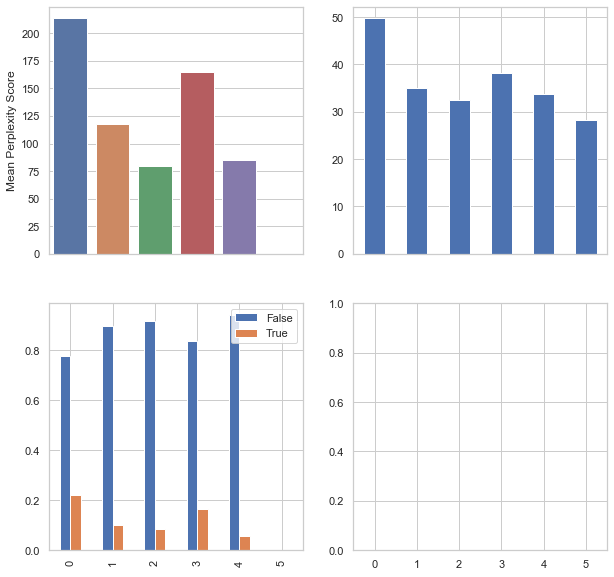

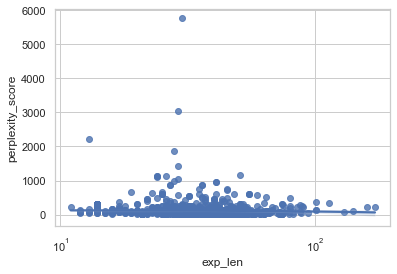

In [7]:
# average P scores per label
# amount of grammatical errors per label / # of that label
sns.set(style="whitegrid")
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True)

pScores = {}
gCheck = {}

for x in range (5):
    x+=1
    
    # Mean perplexity score per label
    pScores[x] = train[train['label'] == x].perplexity_score.mean()
    
    # Average amount of exp's where errors were found per label
    gCheck[x] = train[train['label'] == x].grammar_check.value_counts()/len(train[train['label'] == x])

    

### Create Plots

# Mean Perplexity per class
g = sns.barplot(x=list(pScores.keys()), y=list(pScores.values()),ax=axes[0,0])
g.set(xlabel="Label",ylabel="Mean Perplexity Score")
list(pScores.values())

# Grammar check results per class
gCheck = pd.DataFrame(gCheck).transpose()
gCheck.plot(kind='bar', ax=axes[1,0])

# Mean Length of Sentences per class
train['exp_len'] = train['exp'].str.len()
train.groupby(['label'])['exp_len'].mean().plot(kind='bar', ax=axes[0,1])

# Correlation between sentence length and perplexity
plt.figure()
sns.regplot(x='exp_len',y='perplexity_score', data = train).set_xscale('log')
g.set(xscale='linear')
train['exp_len']
print("Correlation between Explanation Length and Perplexity Score:", np.corrcoef(train['exp_len'],train['perplexity_score'])[0,1])
# No correlation

In [16]:
pScores
train[train['label'] != 1].perplexity_score.mean(), train[train['label'] != 1].perplexity_score.std()


(104.28691036295955, 241.2789982132631)

[(0, 0.015)]

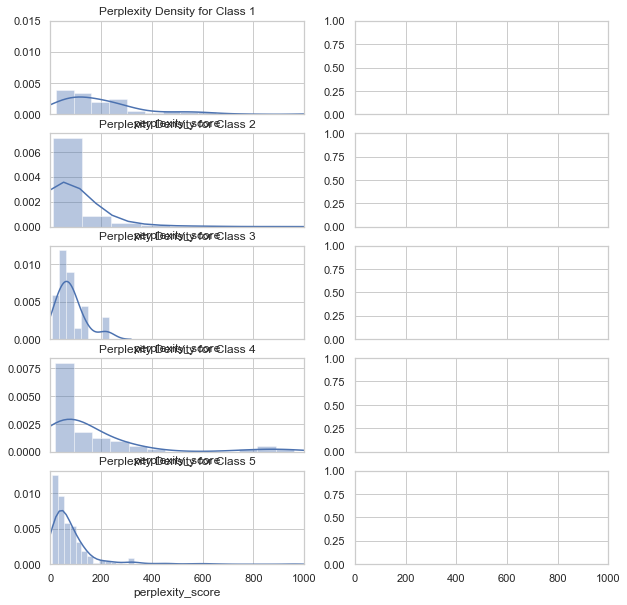

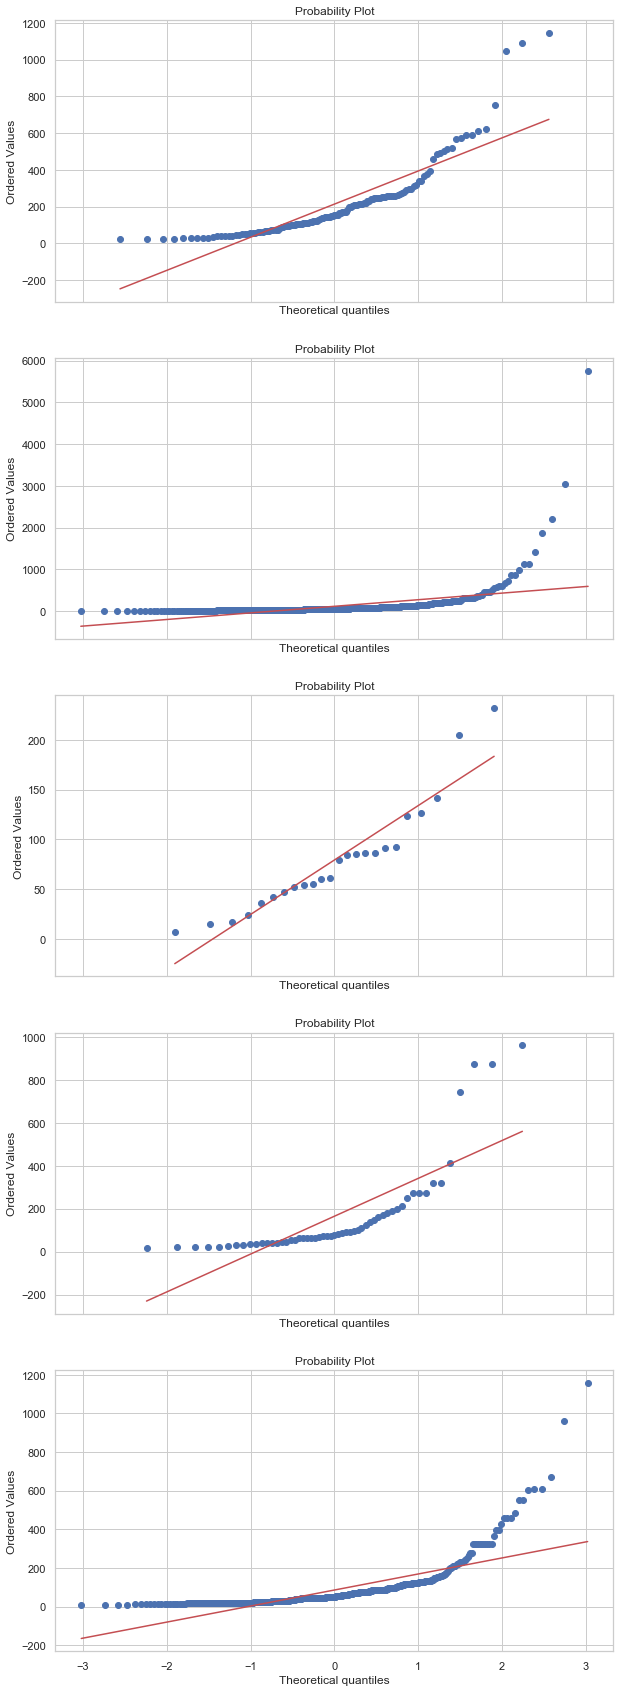

In [13]:
import scipy.stats as stats
f, axes = plt.subplots(5, 2, figsize=(10, 10), sharex=True)
p, paxes = plt.subplots(5, 1, figsize=(10, 30), sharex=True)
for label in range(5):
    label+=1
    
    sns.distplot(train[train['label'] == label].perplexity_score, ax=axes[label-1,0]).set(title= f"Perplexity Density for Class {label}")
    stats.probplot(train[train['label'] == label].perplexity_score, plot=paxes[label-1])
    
    #sns.qqplot(train[train['label'] == label].exp_len, ax=axes[label-1,1]).set(title= f"Exp_len Density for Class {label}")

axes[0,0].set(xlim=(0,1000))
axes[0,0].set(ylim=(0,0.015))
#axes[:,1].set()
# g.set(xlabel="Label",ylabel="Mean Perplexity Score")
# list(pScores.values())

## Data is not normaly distributed, can I still use StDev to calculate good treshhold?

I need to determine the best treshold to use in order to classify most class 1's correctly.

Current plan: Train a model to use perplexity score to classify class-1-error or not. See what it uses as threshold.

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

train.loc[train['label'] != 1, 'label'] = 0

clf = LogisticRegression(random_state=42).fit(train.perplexity_score.to_numpy().reshape(-1, 1),train.label.to_numpy())
# #cross_val_score(clf, , , cv=10)

clf.coef_

c:\users\jokmenen\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
c:\users\jokmenen\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[0.0011963]])

In [19]:
# print(train.perplexity_score)
#print(train[train.label == 1,'perplexity_score'])
for lab in [0,1]:
    print("Label:", lab)
    print('mean: {}'.format(train[train.label == lab].perplexity_score.mean()))
    print('var: {}'.format(train[train.label == lab].perplexity_score.var()))
    print('sd: {}'.format(train[train.label == lab].perplexity_score.std()))
    print()
    
# Mean of 1 is higher, but both std's are very high.



Label: 0
mean: 104.28691036295955
var: 58215.554978795815
sd: 241.2789982132631

Label: 1
mean: 213.46912685351248
var: 41683.93446948523
sd: 204.1664381564346



## Permutation test

In [20]:
from tqdm import tqdm

P = 10000
obs1 = train[train.label == 1][['perplexity_score']]
obs0 = train[train.label == 0][['perplexity_score']]

N = len(obs1)
M = len(obs0)

obs = pd.concat([obs1,obs0]).to_numpy()
out = np.empty(P)

for x in tqdm(range(P)):
    np.random.shuffle(obs)
    
    perm_data_1 = obs[:N]
    perm_data_0 = obs[N+1:]
    
    diff_means = perm_data_1.mean()-perm_data_0.mean()
    out[x] = diff_means
    


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 759.13it/s]


perplexity_score    0.011017
dtype: float64


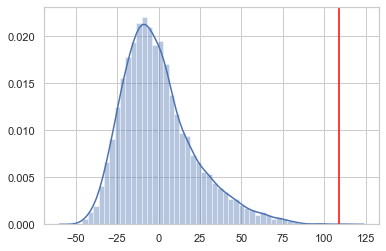

In [21]:
obs_diff_means = obs1.mean()-obs0.mean()
prob = (obs_diff_means+1)/(P+1)
print(prob)

fig = plt.figure()
sns.distplot(out)

plt.axvline(float(obs_diff_means), color = 'red')

# p<0.05, thus we can reject the H0 that the explanations with label 1 and those with a different label come from the same distribution.
# We can therefore assume that the mean perplexity score for explanations labeled clarity error is higher than those labeled differently.

## Bootstrap for accuracy of mean + SE bounds
Plan is to determine the accuracy of both means, to see if there is a way to determine a good threshold using SE's

In [101]:
B = 10000

out_boot = np.empty((B,4))

obs1_b = obs1.to_numpy().flatten()
obs0_b = obs0.to_numpy().flatten()



for b in tqdm(range(B)):
    boot_samp_1 = np.random.choice(obs1_b,len(obs1),True)
    boot_samp_0 = np.random.choice(obs0_b,len(obs0),True)
    
    boot_1_mean = boot_samp_1.mean()
    boot_1_var = boot_samp_1.std()
    boot_0_mean = boot_samp_0.mean()
    boot_0_var = boot_samp_0.std()
    
    out_boot[b] = boot_1_mean, boot_1_var, boot_0_mean, boot_0_var

out_boot



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 10347.10it/s]


array([[237.4845986 , 238.35773704,  97.85597251, 151.31009869],
       [196.29221191, 179.34431028, 115.50002297, 281.12670252],
       [223.59033801, 207.27380347,  93.37798761, 171.43269394],
       ...,
       [212.71737177, 195.92458369, 111.7645355 , 271.97678694],
       [220.91538665, 212.82495734,  99.24347885, 220.04737276],
       [208.09362254, 175.20602503, 100.31953952, 280.03886455]])

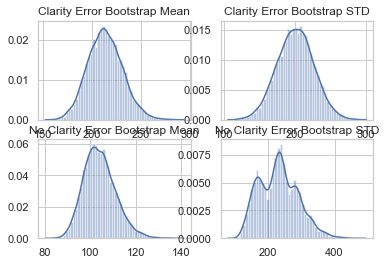

In [102]:
f, axes = plt.subplots(2,2)
sns.distplot(out_boot[:,0], ax=axes[0,0])
sns.distplot(out_boot[:,1], ax=axes[0,1])
sns.distplot(out_boot[:,2], ax=axes[1,0])
sns.distplot(out_boot[:,3], ax=axes[1,1])


axes[0,0].set_title('Clarity Error Bootstrap Mean')
axes[0,1].set_title('Clarity Error Bootstrap STD')
axes[1,0].set_title('No Clarity Error Bootstrap Mean')
axes[1,1].set_title('No Clarity Error Bootstrap STD')



In [22]:
import scipy

fig = plt.figure()
sns.distplot(out_boot[:,0])
sns.distplot(out_boot[:,2], color='red')
h = out_boot[:,2].std() * scipy.stats.t.ppf((1 + 0.99) / 2., n-1)
m = out_boot[:,2].mean()
lb = m-h
ub = m+h
plt.axvline(float(lb), color = 'red')
plt.axvline(float(ub), color = 'red')

qlb = np.percentile(out_boot,.01)
md = np.percentile(out_boot,.50)
qub = np.percentile(out_boot,.99)
print(f"non_class1 Bootstrapped Mean: \nmean:{m} | median: {md}\
    \nlower 99%: CI {lb} | PI {qlb}\
    \nupper 99%: CI {ub} | PI {qub}")

# Too skewed to trust CI's

print(out_boot[:,1].mean(), out_boot[:,3].mean())


NameError: name 'out_boot' is not defined

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x188407937b8>,
 <a list of 50 Text xticklabel objects>)

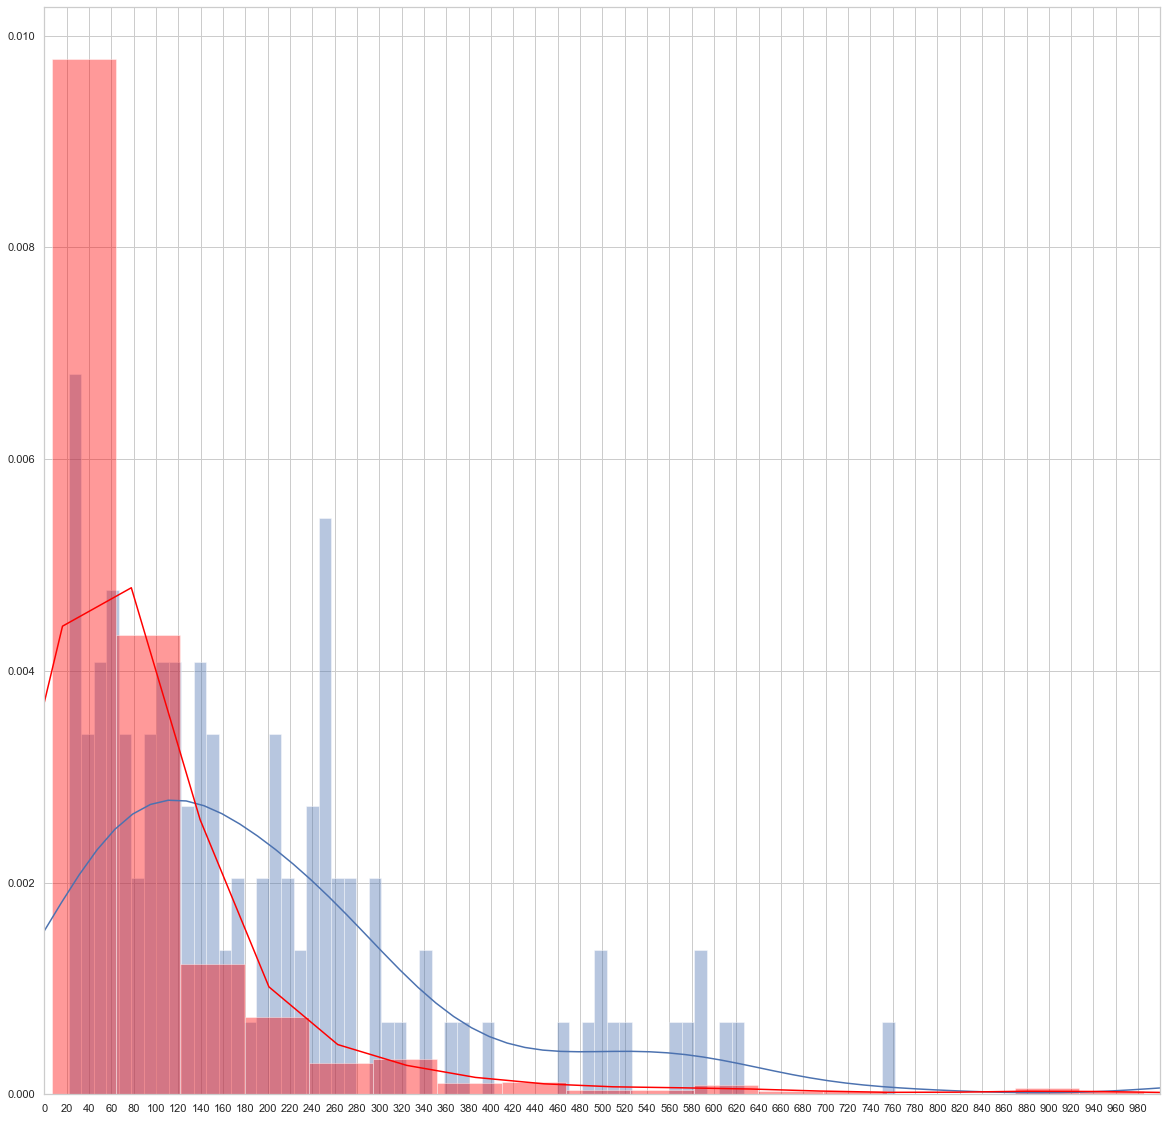

In [252]:

fig = plt.figure(figsize=(20,20))
sns.distplot(obs1,bins=100)
sns.distplot(obs0,bins=100, color = 'red').set_xlim(0,1000)
plt.xticks(range(0,1000,20))

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

#out = {}
def get_scores_perplex(data, trs,grammar_check):
    c1 = data
    c1['pred'] = np.nan
    if grammar_check == True:
        c1.loc[(c1.perplexity_score > trs) | (c1.grammar_check == True), 'pred'] = 1
        c1.loc[(c1.perplexity_score < trs) & (c1.grammar_check == False),'pred'] = 0
    else:
        c1.loc[(c1.perplexity_score > trs), 'pred'] = 1
        c1.loc[(c1.perplexity_score < trs), 'pred'] = 0
    rec = recall_score(c1.label,c1.pred)
    pre = precision_score(c1.label,c1.pred)
    f1 = f1_score(c1.label,c1.pred)
    acc = accuracy_score(c1.label,c1.pred)
    return rec, pre, f1, acc

# gram_check = True
# for trs in tqdm(range(0,300)):
#     #print(f"treshold: {trs}")

#     rec, pre, f1, acc = get_scores_perplex(train,trs,gram_check)
    
#     #print(f"accuracy:{acc}, f1:{f1}, rec:{rec}, pre:{pre}")
#     #print()
#     out[trs] = [rec, pre, f1, acc]

    
# out = pd.DataFrame(out).T
# out.columns = ['recall','precision','f1','acc']
# out


In [29]:
# Try on Test

with pd.option_context('mode.chained_assignment', None):
    for idx,exp in test['exp'].iteritems():
        test.loc[test.index == idx, 'perplexity_score'] = score(exp)
        test.loc[test.index == idx, 'grammar_check'] = len(tool.check(exp))>0


In [30]:
test.loc[test.label != 1, 'label'] = 0
test.label.unique()

print("""Test scores:
    Recall: {}
    Precision: {}
    F1: {}
    Acc: {}""".format(*get_scores_perplex(test,134,True)))

Test scores:
    Recall: 0.7288135593220338
    Precision: 0.23497267759562843
    F1: 0.35537190082644626
    Acc: 0.76


c:\users\jokmenen\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
c:\users\jokmenen\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,ans,exp,pred,qstr,label,comment,grammar_check,perplexity_score
451463000,yes,The sky is bright and there is no sunlight.,NaN,is it night time,0,2e deel van de zin spreekt de 1e tegen,NaN,33.000459
488697002,frisbee,The man is catching a frisbee in his hands.,NaN,what activity are they enjoying,0,NaN,NaN,83.476115
88244002,yes,There are personal effects on the mantel.,NaN,is this a hotel,0,Personal effects = persoonlijke eigendommen ma...,NaN,46.618252
457986001,yes,The door is on the ground.,NaN,does this home have an open floor plan,0,NaN,NaN,40.625745
326664000,skateboarding,The man is riding a skateboard.,NaN,what sport is this,0,gender,NaN,116.577676
570088004,giraffe,It has a long neck and is caged at the zoo.,NaN,what kind of animal is this,0,NaN,NaN,73.222783
184778002,yes,There is a street and a hedge and a buildings ...,NaN,is this a park,1,NaN,NaN,90.461582
408736004,siamese,It has the wrinkly logo and a collar.,1.0,what kind of cat is this,0,kan ook 1 zijn,NaN,241.617224
487931002,soccer,The players are kicking a soccer ball.,NaN,what sport is being played,0,NaN,NaN,98.114194
361265002,yes,The ground is wet and the sky is grey.,NaN,is it raining,0,NaN,NaN,24.615628


In [247]:
out.nlargest(5,'f1')
# Without grammar check --> f1=0.38 acc 0.819 | threshold = 137
# With grammar check --> f1=0.37, acc=0.78 | threshold = 134
# Conclusion --> Use only perplexity score

,recall,precision,f1,acc
134,0.641221,0.255319,0.365217,0.778452
135,0.641221,0.255319,0.365217,0.778452
136,0.641221,0.255319,0.365217,0.778452
137,0.641221,0.255319,0.365217,0.778452
133,0.641221,0.253776,0.363636,0.776935


In [248]:
trs = 137
c1 = train
c1['pred'] = np.nan
c1.loc[c1.perplexity_score > trs,'pred'] = 1
c1.loc[c1.perplexity_score < trs,'pred'] = 0

len(c1[((c1.label == 1) & (c1.pred == 1))]), len(c1[((c1.label == 0) & (c1.pred == 1))])
# TP | FP

c:\users\jokmenen\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(74, 181)

In [246]:
len(c1[(c1.grammar_check == 1) & (c1.label == 0)])

99

## Try full detector


In [250]:
from Explanation_error_detector import Explanation_error_detector

eer = Explanation_error_detector()

test['exp']


#### TRY LATER

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


NameError: name 'self' is not defined

,ans,exp,pred,qstr,label,comment,grammar_check,perplexity_score,exp_len
427762007,surfboard,He is on a board on the water.,surfboard,what is the man sitting on,0,NaN,False,74.927050,30
214447000,no,They are on skis.,yes,are the people skiing,0,kan ook 2,False,145.268786,17
155319003,kite,It is a diamond and has a tail.,kite,what is this person holding,0,NaN,False,72.760052,31
29838029,yes,There are vegetables and nuts.,yes,is this healthy food,0,NaN,False,113.914305,30
296988004,truck,It is a large vehicle on a roadway and has a t...,truck,what kind of vehicle is shown,0,NaN,False,105.532252,74
347823001,birthday,There are candles on the cake.,birthday,what kind of party is this,0,NaN,False,71.365948,30
491725001,yes,There are boats lined up together on the water.,yes,is this a harbor,0,NaN,False,48.133097,47
463918000,wii,They are holding wii controllers.,wii,what game are they playing,0,NaN,True,200.508012,33
35672002,yes,It is sleeping and comfortable.,yes,does the animal in this photo look happy,0,NaN,False,213.875000,31
190185001,no,It is a plate with sweet of goods.,no,does this sandwich look healthy,0,NaN,False,342.306234,34


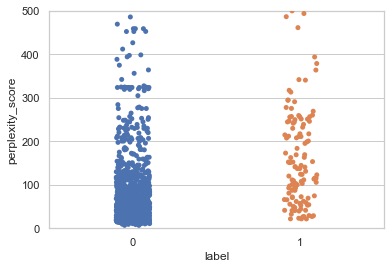

In [15]:
fig = plt.figure()

g = sns.stripplot(x="label",y="perplexity_score", data=train, jitter=True)
g.set_ylim(0,500)
# 
# 
# 
#train

train.groupby('label').quantile(.15)
# A threshold of 55 cause 50% false positives and ~15% false negatives of all the 

# Check the type of sentences that I classified as type 1 error got low perplexity score
train[(train.label == 1) & (train.perplexity_score <40)]

# and the sentences that got a high perplexity score but were not classified as type 1:
train[(train.label == 0) & (train.perplexity_score >40)]

In [320]:
train[train.perplexity_score == train.perplexity_score.max()],
train[train.perplexity_score == train.perplexity_score.min()]

train.perplexity_score.quantile(.99)

945.3162319109159

In [10]:
#SPACY
clarity_error_exps = data[data['label'] == 1]['exp']
#matches = {}

doc = nlp(clarity_error_exps.iloc[5])
doc._.has_grammar_error  # True



# fails = {}
# for idx,exp in clarity_error_exps.iteritems():
#     m = tool.check(exp)
#     if m[0].ruleId == 'UPPERCASE_SENTENCE_START':
#         m = m[1:]
#     if len(m)>0:    
#         matches[idx] = [m, exp]
#     else:
#         matches[idx] = ['No Error Found', exp]
#         fails[idx] = exp



AttributeError: [E046] Can't retrieve unregistered extension attribute 'has_grammar_error'. Did you forget to call the `set_extension` method?

In [94]:
# for x in fails.values():
#     print(x.capitalize() + '.')

(len(matches)-len(fails))/len(matches)

0.23684210526315788

In [107]:
data = pd.read_csv('googlebooks-eng-all-2gram-20120701-0', sep='\t')

In [11]:
sent = matches[537672004][1]

# Construction 1
# from spacy.tokenizer import Tokenizer
# from spacy.lang.en import English
# #nlp = English()

# Create a blank Tokenizer with just the English vocab
#tokenizer = Tokenizer(nlp.vocab)

sent
# p = nlp(sent)
# # for token in p:
# #     print(token.prob)
# list(p.noun_chunks)

'there is a refrigerator and a refrigerator'

In [4]:
#!python -m spacy download en_core_web_md
import spacy
nlp = spacy.load('en_core_web_md')
s1 = 'The clouds moved like diaphanous folds in a gentle breeze.'
s2 = 'The clouds moved like gossamer folds in a gentle breeze.'
s3 = 'The clouds moved like translucent folds in a gentle breeze.'
s_list = [s1, s2, s3]
for s in s_list:
  doc = nlp(s)
  for token in doc:
    print(token.orth_, token.prob)

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


The -5.958707332611084
clouds -11.937688827514648
moved -9.661837577819824
like -5.610429763793945
diaphanous -18.54680633544922
folds -13.35114860534668
in -4.619071960449219
a -3.92978835105896
gentle -11.988629341125488
breeze -12.588302612304688
. -3.0678977966308594
The -5.958707332611084
clouds -11.937688827514648
moved -9.661837577819824
like -5.610429763793945
gossamer -17.05768585205078
folds -13.35114860534668
in -4.619071960449219
a -3.92978835105896
gentle -11.988629341125488
breeze -12.588302612304688
. -3.0678977966308594
The -5.958707332611084
clouds -11.937688827514648
moved -9.661837577819824
like -5.610429763793945
translucent -13.898991584777832
folds -13.35114860534668
in -4.619071960449219
a -3.92978835105896
gentle -11.988629341125488
breeze -12.588302612304688
. -3.0678977966308594


Simple NN approach

In [91]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

data = pd.read_csv('Post_processing.csv', index_col=0)

data = data[['exp', 'label']]
data['label'][data['label'] != 1] = 0
X = list(data['exp'])

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)

y = list(data['label'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)




In [92]:
ones = []

for label, exp in zip(y_train,X_train):
    if label == 1:
        ones += [exp]

X_train = np.append(np.array(X_train), np.random.choice(ones,sum([x==0 for x in y_train ]) -
                                sum([x==1 for x in y_train ])))
while len(y_train) < X_train.shape[0]:
    y_train += [1]
len(y_train) , X_train.shape
# while sum([x==1 for x in y_train ])<sum([x==0 for x in y_train ]):
    
    

(1318, (1057,))

In [94]:
#len(X_train), len(X_test), len(y_train), len(y_test)

print(sum([x==1 for x in y ])/len(y),'% is 1')

0.0665650406504065 % is 1


In [59]:
#model definition
import collections
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from tensorflow.keras import layers, metrics

METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
]

model = tf.keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128, activation = 'relu'))

# Add a Dense layer with 10 units.
model.add(layers.Dense(10,activation = 'relu'))

model.add(layers.Dense(1,activation = 'sigmoid'))

model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=METRICS)

model.fit(X_train,y_train,epochs=3,batch_size=32)

model.evaluate(X_test,y_test)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 64)          64000     
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 11        
Total params: 164,117
Trainable params: 164,117
Non-trainable params: 0
_________________________________________________________________
Train on 1318 samples
Epoch 1/3
1318/1318 [==============================] - 62s 47ms/sample - loss: 0.6727 - tp: 4.0000 - fp: 28.0000 - tn: 1159.0000 - fn: 127.0000 - accuracy: 0.8824 - precision: 0.1250 - recall: 0.0305 - auc: 0.4964
Epoch 2/3

[0.6405869911267207, 0.0, 0.0, 591.0, 59.0, 0.90923077, 0.0, 0.0, 0.5]

In [58]:
print(tf.__version__)

1.14.1-dev20190530
